In [1]:
import pandas as pd
import glob
from itertools import product, combinations
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

### To dos:
- Consider whether to evaluate multiple models?
- Run model on seinfeld, 10 and keep true/true_id to look at:
    - Distributions per se
    - Difference in probability distributions across baselines by quantiles
    - ... Draw conclusions on whether indiscriminately increasing uncertainty and surprisal
- Plot surprisal for true vs. non-true for a couple of examples
    - ... Interpret dynamics over context sizes
- Plot distribution of what models get wrong in noise conditions
    - ... To understand if there's patterns in what the model gets wrong

## Read in data and plot

In [117]:
logs = glob.glob('outputs/narratives_gpt3/*')
logs = [l for l in logs if '_100_' not in l]

In [118]:
metrics = ['loss', 'is_top_true', 'surprisal', 'entropy']

In [119]:
for i, l in enumerate(logs):
    ldf = pd.read_csv(l, sep='\t', index_col=0)
    if i % 100 == 0:
        print(f'{i} of {len(logs)}')
    if l == logs[0]:
        all_logs = ldf
    else:
        all_logs = pd.concat([all_logs, 
                              ldf], ignore_index=True)
all_logs['is_top_true'] = (all_logs['target'] == all_logs['top_predicted']).astype(int)
all_logs['surprisal'] = -np.log2(all_logs['prob_true'])
all_logs['case_sensitive'] = all_logs['case_sensitive'].replace({'transcript': 'baseline', 
                                                                 'align_upper': '- punctuation',
                                                                 'align_lower_nounk': '- casing',
                                                                 'align_lower_unk': '- casing noised'})
aggs = all_logs.groupby(['case_sensitive', 
                         'model', 
                         'context_size', 
                         'dataset'])[metrics].mean().reset_index()


0 of 677
100 of 677
200 of 677
300 of 677
400 of 677
500 of 677
600 of 677


In [120]:
datasets = all_logs.dataset.unique().tolist()
context_size = all_logs.context_size.unique().tolist()
types = ['baseline', '- punctuation', '- casing', '- casing noised']

Plot overall behavior in all four cases

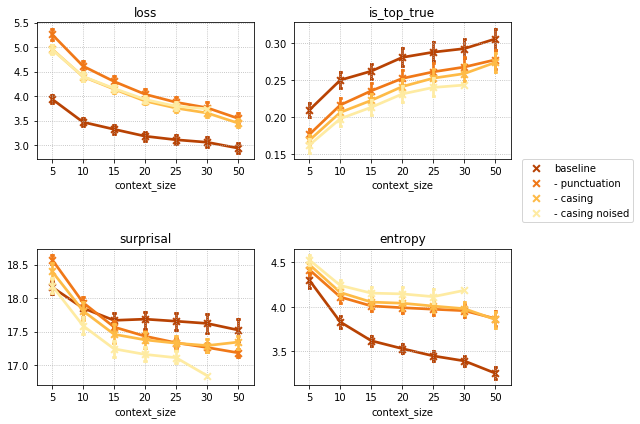

In [121]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(9,6)) # 7
idx = list(product([0,1], [0,1]))
for i, m in enumerate(metrics):
    sns.pointplot(data=aggs, 
                  x='context_size', 
                  y=m, 
                  hue='case_sensitive', 
                  ax=ax[idx[i]],
                  hue_order=types,
                  palette='YlOrBr_r', 
                  markers='x', 
                  capsize=.05) # add row=model or hue=model
    ax[idx[i]].set_title(m)
    ax[idx[i]].set_ylabel('')
    if i!=1:
        ax[idx[i]].get_legend().remove()
    else:
        ax[idx[i]].legend(bbox_to_anchor=(1.05, .0), 
                     loc=2, 
                     borderaxespad=0.)
    ax[idx[i]].grid(linestyle='dotted')
plt.tight_layout()
plt.show()

Plot baseline behavior alone

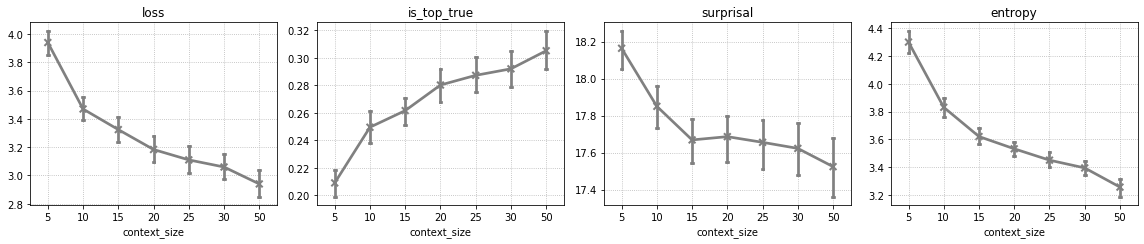

In [114]:
fig, ax = plt.subplots(ncols=4, figsize=(16,3.5)) # 7
for i, m in enumerate(metrics):
    sns.pointplot(data=aggs[aggs['case_sensitive']=='baseline'], 
                  x='context_size', 
                  y=m, 
                  ax=ax[i],
                  markers='x', 
                  color='grey',
                  capsize=.05) # add hue=model?
    ax[i].set_title(m)
    ax[i].set_ylabel('')
    ax[i].grid(linestyle='dotted')
plt.tight_layout()
plt.show()

Plot behavior in noised corpora as difference from baseline

In [140]:
refs = aggs[aggs['case_sensitive']=='baseline']

In [141]:
ds = []
for d in datasets:
    for t in types[1:]:
        a = aggs[(aggs['dataset']==d) & (aggs['case_sensitive']==t)].sort_values(by='context_size')
        r = refs[(refs['dataset']==d)].sort_values(by='context_size')
        for m in metrics:
            a[m] = a[m].values-r[m].values
        ds.append(a)
ds = pd.concat(ds)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(9,6)) # 7
idx = list(product([0,1], [0,1]))
for i, m in enumerate(metrics):
    sns.pointplot(data=ds, 
                  x='context_size', 
                  y=m, 
                  hue='case_sensitive', 
                  ax=ax[idx[i]],
                  hue_order=types[1:],
                  palette=sns.color_palette("YlOrBr_r", 4)[1:], 
                  markers='x', 
                  capsize=.05)
    ax[idx[i]].set_title(m)
    ax[idx[i]].set_ylabel('')
    if i!=1:
        ax[idx[i]].get_legend().remove()
    else:
        ax[idx[i]].legend(bbox_to_anchor=(1.05, .0), 
                     loc=2, 
                     borderaxespad=0.)
    ax[idx[i]].axhline(0.0, color='black', linestyle='dashed')
    ax[idx[i]].grid(linestyle='dotted')
    if i in [0,2]:
        ax[idx[i]].set_ylabel('change from baseline')
plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (5,) (7,) 

In [142]:
ds = []
for d in datasets:
    for t in types[1:]:
        a = aggs[(aggs['dataset']==d) & (aggs['case_sensitive']==t)].sort_values(by='context_size')
        r = refs[(refs['dataset']==d)].sort_values(by='context_size')
        for m in metrics:
            a[m] = (a[m].values-r[m].values)/r[m].values
        ds.append(a)
ds = pd.concat(ds)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(9,6)) # 7
idx = list(product([0,1], [0,1]))
for i, m in enumerate(metrics):
    sns.pointplot(data=ds, 
                  x='context_size', 
                  y=m, 
                  hue='case_sensitive', 
                  ax=ax[idx[i]],
                  hue_order=types[1:],
                  palette=sns.color_palette("YlOrBr_r", 4)[1:], 
                  markers='x', 
                  capsize=.05)
    ax[idx[i]].set_title(m)
    ax[idx[i]].set_ylabel('')
    if i!=1:
        ax[idx[i]].get_legend().remove()
    else:
        ax[idx[i]].legend(bbox_to_anchor=(1.05, .0), 
                         loc=2, 
                         borderaxespad=0.)
    ax[idx[i]].axhline(0.0, color='black', linestyle='dashed')
    ax[idx[i]].grid(linestyle='dotted')
    #if i in [0,2]:
    #    ax[idx[i]].set_ylabel('% change from baseline')
plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (5,) (7,) 

### Pairwise correlations

In [143]:
from itertools import combinations
pairs = list(combinations(types, 2))

In [146]:
outs = []
for d in datasets:
    for c in context_size:
        for p in pairs:
                ds = all_logs[all_logs['dataset']==d]
                ds = ds[ds['context_size']==c]
                p1 = ds[ds['case_sensitive']==p[0]]
                p2 = ds[ds['case_sensitive']==p[1]]
                for m in metrics:
                    cc = np.corrcoef(p1[m], p2[m])[0,1]
                    outs.append((m,d,c,p[0],p[1],cc))
outd = pd.DataFrame(outs, 
                    columns=['metric',
                             'dataset',
                             'context',
                             'type0',
                             'type1',
                             'corr'])

In [147]:
ags = outd.groupby(['metric', 'context', 
                    'type0', 'type1'])['corr'].mean().reset_index()
ags = ags[ags['type0']=='baseline'].drop('type0', axis=1)

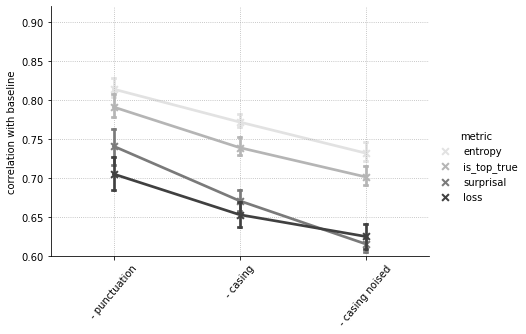

In [148]:
sns.catplot(data=ags, hue='metric', 
            x='type1', y='corr', 
            kind='point', 
            order=['- punctuation', '- casing', '- casing noised'], 
            palette=sns.color_palette("Greys", 4),
            hue_order=['entropy', 'is_top_true', 'surprisal', 'loss'], 
            height=4, aspect=1.5, 
            markers='x',
            capsize=.02)
plt.ylim(.6,.92)
plt.xlabel('')
plt.ylabel('correlation with baseline')
plt.xticks(rotation=50)
plt.grid(linestyle='dotted')
plt.show()

In [102]:
all_logs['id'] = all_logs.groupby(['dataset', 
                                   'case_sensitive',
                                   'context_size']).cumcount()+1;

In [103]:
viz = all_logs.pivot(index=['dataset', 'model', 'context_size', 'id'], 
                     columns='case_sensitive', 
                     values=['top_predicted', 'context']).reset_index()
viz.columns = ['dataset', 'model', 'context_size', 'id', 
               '- casing', '- casing noised', '- punctuation', 'baseline',
               '- casing context', '- casing noised context', 
               '- punctuation context', 'baseline context']
viz = viz[['dataset', 'model', 'context_size', 'id', 
           'baseline', '- punctuation', '- casing', '- casing noised', 
           'baseline context', '- punctuation context', 
           '- casing context',  '- casing noised context']]

In [104]:
pd.options.display.max_colwidth = 300
display(viz[viz['context_size']==10][viz['baseline']!=viz['- punctuation']].sample(n=20).iloc[:,2:30])

<ipython-input-104-15a375705f60>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(viz[viz['context_size']==10][viz['baseline']!=viz['- punctuation']].sample(n=20).iloc[:,2:30])


,context_size,id,baseline,- punctuation,- casing,- casing noised,baseline context,- punctuation context,- casing context,- casing noised context
11124,10,2863,Thatcher,'s,.,.,"family session, it will help us all loosen up Margaret",family session it will help us all loosen up Margaret,family session it will help us all loosen up margaret,family session it will help us all loosen up margaret
84431,10,1274,\n,",",.,.,performed as Mary Livingston. All these names in my head.,performed as Mary Livingston All these names in my head,performed as mary livingston all these names in my head,performed as mary livingston all these names in my head
14965,10,6704,"""",",",.,.,folds up the pull out couch. Her voice sounds pragmatic:,folds up the pull out couch Her voice sounds pragmatic,folds up the pull out couch her voice sounds pragmatic,folds up the pull out couch her voice sounds pragmatic
213855,10,536,I,.,.,.,"gonna go back and get my umbrella,” because it’s raining.",gonna go back and get my umbrella because it’s raining,gonna go back and get my umbrella because it's raining,gonna go back and get my umbrella because it's raining
153010,10,829,a,",",",",<,"a kitchen chair, to an aluminum, uh, kitchen dinette, uh,",a kitchen chair to an aluminum uh kitchen dinette uh,a kitchen chair to an aluminum uh kitchen dinette uh,a kitchen chair to an aluminum uh kitchen <unk> uh
234714,10,120,\n,?,?,?,was this thing called key money. Does anybody remember that?,was this thing called key money Does anybody remember that,was this thing called key money does anybody remember that,was this thing called key money does anybody remember that
215517,10,2198,I,",",",",",","seen lots of like gruesome, violent things And then, uh,",seen lots of like gruesome violent things And then uh,seen lots of like gruesome violent things and then uh,seen lots of like gruesome violent things and then uh
213917,10,598,'s,is,is,is,"that appears again and we assume that the, um, that",that appears again and we assume that the um that,that appears again and we assume that the um that,that appears again and we assume that the um that
169792,10,624,",",.,istically,istically,"drop box, made his delivery, and fled away, crying, “Ego",drop box made his delivery and fled away crying Ego,drop box made his delivery and fled away crying ego,drop box made his delivery and fled away crying ego
192549,10,459,I,you,you,you,"you gotta do ""I don't know ""Just end up where",you gotta do I don't know Just end up where,you gotta do i don't know just end up where,you gotta do i don't know just end up where


### Examples from each dataset type

In [105]:
all_logs[all_logs['dataset']=='seinfeld'][all_logs['id']==9][all_logs['target']!=all_logs['orig_wd']][all_logs['context_size']==20]

<ipython-input-105-92a9e3d4c693>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_logs[all_logs['dataset']=='seinfeld'][all_logs['id']==9][all_logs['target']!=all_logs['orig_wd']][all_logs['context_size']==20]
<ipython-input-105-92a9e3d4c693>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_logs[all_logs['dataset']=='seinfeld'][all_logs['id']==9][all_logs['target']!=all_logs['orig_wd']][all_logs['context_size']==20]


,dataset,model,context,target,orig_wd,top_predicted,loss,entropy,prob_true,prob_predicted,context_size,case_sensitive,is_top_true,surprisal,id
133281,seinfeld,gpt2,their suitcases George walked quickly grimacing as he scanned the signs to figure out which way to go A man,pass,passing,in,4.382879,5.365333,0.000001,0.115491,20,- punctuation,0,19.607647,9
463500,seinfeld,gpt2,their suitcases george walked quickly <unk> as he scanned the signs to figure out which way to go a man,pass,passing,was,5.924784,5.605934,0.000005,0.057064,20,- casing noised,0,17.534597,9
629980,seinfeld,gpt2,"their suitcases. George walked quickly, grimacing as he scanned the signs to figure out which way to go. A man",pass,passing,in,3.853528,4.950641,0.000003,0.142569,20,baseline,0,18.532299,9
1120866,seinfeld,gpt2,their suitcases george walked quickly grimacing as he scanned the signs to figure out which way to go a man,pass,passing,was,5.521465,4.767756,0.000004,0.125748,20,- casing,0,17.962150,9
